In [109]:
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sys, os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),"../../")))

from Lamp.AttrDict.AttrDict import *
from Lamp.Model.Dataloader import *


In [110]:
cfg_path = '../Models/config/MAR_RESNET18_PADDED_256_ALL_NEW.yaml'

inputs = AttrDict.from_yaml_path(cfg_path)
inputs

{'ModelName': 'MAR_RESNET18_PADDED_256_ALL_NEW',
 'PathSave': 'Models/outputs/',
 'LoadPath': 'Dataset/train_mar.csv',
 'LoadPathTestLab': 'Dataset/test_lab_mar.csv',
 'LoadPathTestBorehole': 'Dataset/test_borehole_mar.csv',
 'CheckpointName': 'checkpoint.pt',
 'CheckpointFreq': 5,
 'NSamples': 1000,
 'NEpochs': 200,
 'BatchSize': 32,
 'TrainTestSplit': 0.95,
 'KFold': 5,
 'Seed': 0,
 'Model': {'Name': 'ResNet',
  'Layers': [2, 2, 2, 2],
  'OutClasses': 5,
  'Channels': 1},
 'TransformTrain': {'ToRGB': {'num_output_channels': 3},
  'ColorJitter': {'brightness': 0.5},
  'ToGrayscale': {'num_output_channels': 1},
  'Padding': {'out_shape': 256},
  'VerticalFlip': {'p': 0.5},
  'HorizontalFlip': {'p': 0.5},
  'Rotation': {'min': -90, 'max': 90}},
 'TransformTest': {'Padding': {'out_shape': 256}},
 'Optimizer': {'lr': 0.001, 'weight_decay': 1e-06},
 'Scheduler': {'gamma': 0.95}}

In [111]:
dataframe = pd.read_csv('../Dataset/train_bbox.csv',index_col=0)

# Train Test Split
train_dataframe, _ = train_test_split(dataframe, test_size=(1 - inputs.TrainTestSplit),stratify=dataframe['Label'], random_state=inputs.Seed)

# Reset Index
train_dataframe = train_dataframe.reset_index(drop=True)

# Samples
train_dataframe = train_dataframe.groupby('Label').sample(4,replace=True,random_state=0).reset_index(drop=True)

dict_ = {0:'BL',1:'GN',2:'ML',3:'MS',4:'OL'}


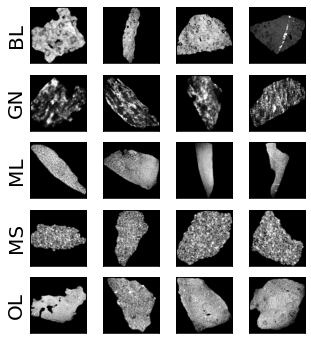

In [112]:
transforms = tf.Compose(
        [   
            Padding(out_shape=256),            
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(train_dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=4*5)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(5,4,figsize=(5,6))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])


    if i_ % 4 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)

plt.savefig('examples.png',bbox_inches='tight')

In [33]:
df = pd.read_csv("../Dataset/train_mar.csv",index_col=0)

In [50]:
df_train = df.loc[df['Paths'] == "../Data/Train/ML3-1-DL\slice00600_mar_raw_5.png"].reset_index(drop=True)

In [59]:
transforms_none = tf.Compose(
        [   
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

transforms_padded = tf.Compose(
        [   
            Padding(out_shape=256),            
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

transforms_resized = tf.Compose(
        [   
            tf.Resize((256,256)),
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

transforms_cropped = tf.Compose(
        [   
            tf.CenterCrop(64),
            tf.Resize((256,256)),
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset_none = Dataset(
    df_train.reset_index(drop=True),
    transforms = transforms_none
    )

trainDataset_padded = Dataset(
    df_train.reset_index(drop=True),
    transforms = transforms_padded
    )

trainDataset_resized = Dataset(
    df_train.reset_index(drop=True),
    transforms = transforms_resized
    )

trainDataset_cropped = Dataset(
    df_train.reset_index(drop=True),
    transforms = transforms_cropped
    )

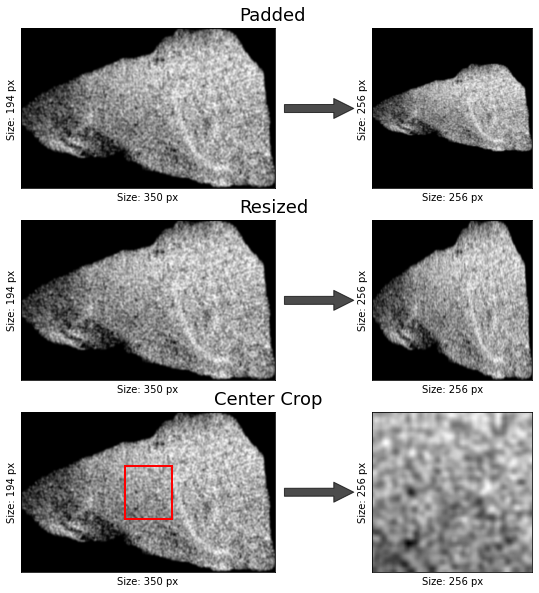

In [108]:
fig, ax = plt.subplots(3,2,figsize=(10,10))

im, label = trainDataset_none.__getitem__(0)

# Padded
ax[0,0].imshow(im[0],cmap='gray',aspect='auto')
ax[0,0].text(300,-10,'Padded',fontsize=18)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_xlabel(f"Size: {im.shape[2]} px")
ax[0,0].set_ylabel(f"Size: {im.shape[1]} px")

ax[0,1].imshow(trainDataset_padded.__getitem__(0)[0][0],cmap='gray', aspect="equal")
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_xlabel(f"Size: {trainDataset_padded.__getitem__(0)[0][0].shape[1]} px")
ax[0,1].set_ylabel(f"Size: {trainDataset_padded.__getitem__(0)[0][0].shape[0]} px")

# Resized
ax[1,0].imshow(im[0],cmap='gray',aspect='auto')
ax[1,0].text(300,-10,'Resized',fontsize=18)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_xlabel(f"Size: {im.shape[2]} px")
ax[1,0].set_ylabel(f"Size: {im.shape[1]} px")

ax[1,1].imshow(trainDataset_resized.__getitem__(0)[0][0],cmap='gray', aspect="equal")
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_xlabel(f"Size: {trainDataset_resized.__getitem__(0)[0][0].shape[1]} px")
ax[1,1].set_ylabel(f"Size: {trainDataset_resized.__getitem__(0)[0][0].shape[0]} px")

# Cropped
ax[2,0].imshow(im[0],cmap='gray',aspect='auto')
ax[2,0].text(265,-10,'Center Crop',fontsize=18)
ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_xlabel(f"Size: {im.shape[2]} px")
ax[2,0].set_ylabel(f"Size: {im.shape[1]} px")

xc = im[0].shape[1] // 2
yc = im[0].shape[0] // 2

ax[2,0].add_patch(patches.Polygon([[xc-32,yc-32],[xc-32,yc+32],[xc+32,yc+32],[xc+32,yc-32]], fill=False, edgecolor='red', linewidth=2))
ax[2,1].imshow(trainDataset_cropped.__getitem__(0)[0][0],cmap='gray', aspect="equal")
ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].set_xlabel(f"Size: {trainDataset_cropped.__getitem__(0)[0][0].shape[1]} px")
ax[2,1].set_ylabel(f"Size: {trainDataset_cropped.__getitem__(0)[0][0].shape[0]} px")

# Add arrows

figtr = fig.transFigure.inverted() 

arrow = patches.FancyArrowPatch(
    figtr.transform(ax[0,0].transData.transform((360., 97.))), 
    figtr.transform(ax[0,1].transData.transform((30., 128.))), 
    transform=fig.transFigure,  # Place arrow in figure coord system
    fc = "k", 
    arrowstyle='simple', 
    alpha = 0.7,
    mutation_scale = 40.
)
fig.patches.append(arrow)

arrow = patches.FancyArrowPatch(
    figtr.transform(ax[1,0].transData.transform((360., 97.))), 
    figtr.transform(ax[1,1].transData.transform((30., 128.))), 
    transform=fig.transFigure,  # Place arrow in figure coord system
    fc = "k", 
    arrowstyle='simple', 
    alpha = 0.7,
    mutation_scale = 40.
)
fig.patches.append(arrow)

arrow = patches.FancyArrowPatch(
    figtr.transform(ax[2,0].transData.transform((360., 97.))), 
    figtr.transform(ax[2,1].transData.transform((30., 128.))), 
    transform=fig.transFigure,  # Place arrow in figure coord system
    fc = "k", 
    arrowstyle='simple', 
    alpha = 0.7,
    mutation_scale = 40.
)
fig.patches.append(arrow)

plt.savefig('dataset.png',bbox_inches='tight')

175